# Imports 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier

sns.set_theme()

# 4. Modelling

In [162]:
df = pd.read_csv("../../../databases/q1_database.csv")
df = df.drop(columns=["Avg Reading Result"])
df.sample(5)

,Avg Math Result,BMMJ1,CNT_Group,CREATOOS,ESCS,FAMCON,HISEI,HOMEPOS,IC171Q02JA,IC173Q04JA,...,ST289Q02JA,ST289Q05WA,ST289Q06JA,ST289Q10WA,ST290Q01WA,ST290Q02WA,ST290Q03WA,ST290Q05WA,ST291Q01JA,ST355Q02JA
265560,376.3219,26.64,Above Average,NaN,-0.8759,-0.2651,36.92,-0.4442,4.0,5.0,...,5.0,NaN,3.0,NaN,1.0,NaN,2.0,3.0,1.0,NaN
391208,541.7421,24.98,Above Average,NaN,-0.0388,0.4098,30.78,0.8069,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,1.0,NaN,4.0,4.0,NaN
268224,382.8235,NaN,Above Average,1.9065,-0.9597,-3.0978,NaN,-1.5960,NaN,NaN,...,NaN,NaN,NaN,1.0,3.0,NaN,3.0,NaN,2.0,NaN
105161,492.5287,81.13,Average,-0.1674,1.6654,0.9072,81.13,1.9866,5.0,3.0,...,4.0,NaN,4.0,NaN,3.0,3.0,2.0,4.0,2.0,NaN
231958,377.3315,NaN,Above Average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
y = df["Avg Math Result"]
X = df.drop(columns=["Avg Math Result"])

repeat_col = X["REPEAT"]
X = X.drop(columns=["REPEAT"])

### Pre-process

In [164]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numerical_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    [
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

X_encoded = preprocessor.fit_transform(X)

onehot_columns = preprocessor.named_transformers_["cat"][
    "onehot"
].get_feature_names_out(categorical_cols)
final_columns = list(numerical_cols) + list(onehot_columns)


X_encoded_df = pd.DataFrame(X_encoded, columns=final_columns)

X_encoded_df["REPEAT"] = repeat_col.reset_index(drop=True)

X_encoded_repeating = X_encoded_df[X_encoded_df["REPEAT"] == 1].drop(columns=["REPEAT"])
X_encoded_not_repeating = X_encoded_df[X_encoded_df["REPEAT"] == 0].drop(
    columns=["REPEAT"]
)

### K-means

In [165]:
kmeans_repeating = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_repeating)
kmeans_not_repeating = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_not_repeating)

In [175]:
repeating = df[df["REPEAT"] == 1].reset_index(drop=True)
repeating["kmeans"] = kmeans_repeating.labels_
X_encoded_repeating["kmeans"] = kmeans_repeating.labels_

not_repeating = df[df["REPEAT"] == 0].reset_index(drop=True)
not_repeating["kmeans"] = kmeans_not_repeating.labels_
X_encoded_not_repeating["kmeans"] = kmeans_not_repeating.labels_

print(repeating.groupby("kmeans")["Avg Math Result"].describe().to_string())
print(not_repeating.groupby("kmeans")["Avg Math Result"].describe().to_string())

          count        mean        std       min         25%        50%         75%       max
kmeans                                                                                       
0       12082.0  348.688187  59.561334  122.8485  306.382700  341.74345  384.130575  661.8582
1       27562.0  399.065672  86.056714   97.6254  334.370125  390.61020  453.875400  763.4544
2       20108.0  323.481965  51.646285   39.1713  290.204850  318.80540  352.623250  636.7595
           count        mean        std       min         25%       50%         75%       max
kmeans                                                                                       
0       217455.0  427.887344  73.245294  105.7688  375.064300  424.4471  476.263250  776.9333
1       110462.0  370.076523  63.497353  121.7875  325.901425  363.1559  407.212375  759.3522
2       179907.0  524.622476  83.578745  189.7535  469.300000  526.5810  581.517000  843.2881


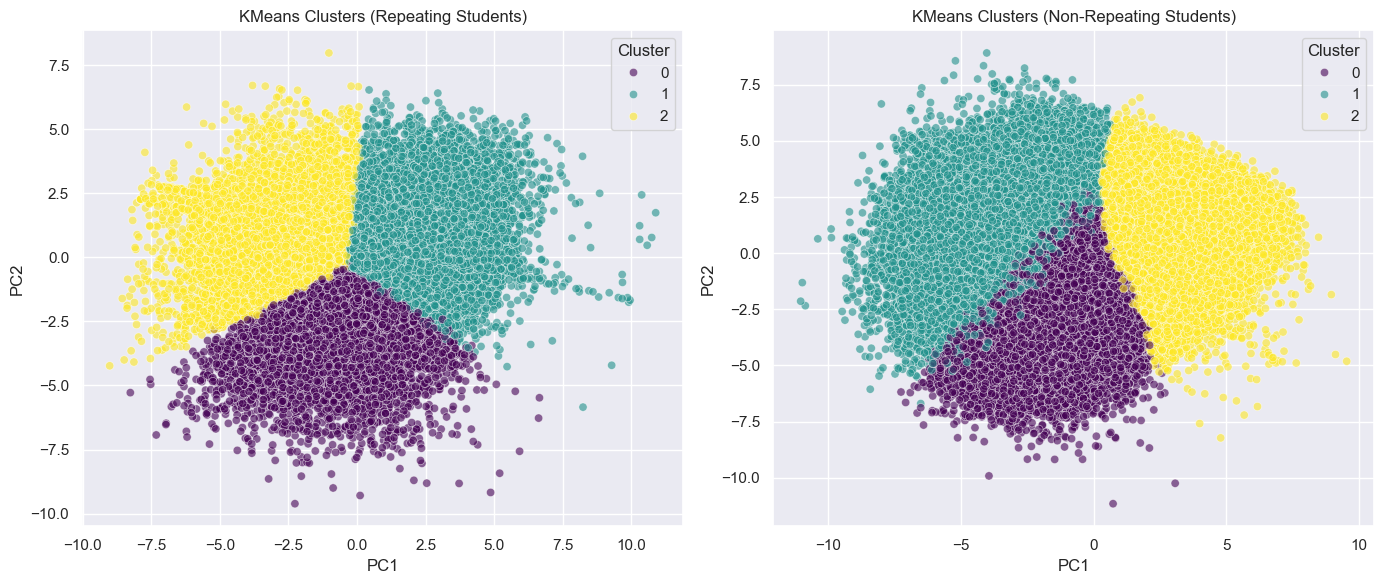

In [176]:
# repeating pca
pca_repeating = PCA(n_components=2)
X_pca_repeating = pca_repeating.fit_transform(X_encoded_repeating)
X_pca_repeating_df = pd.DataFrame(X_pca_repeating, columns=["PC1", "PC2"])
X_pca_repeating_df["Cluster"] = kmeans_repeating.labels_

# not repeating pca
pca_not_repeating = PCA(n_components=2)
X_pca_not_repeating = pca_not_repeating.fit_transform(X_encoded_not_repeating)
X_pca_not_repeating_df = pd.DataFrame(X_pca_not_repeating, columns=["PC1", "PC2"])
X_pca_not_repeating_df["Cluster"] = kmeans_not_repeating.labels_

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(
    data=X_pca_repeating_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_title("KMeans Clusters (Repeating Students)")

sns.scatterplot(
    data=X_pca_not_repeating_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_title("KMeans Clusters (Non-Repeating Students)")
plt.tight_layout()
plt.show()

Ordenar os rótulos por média:

In [184]:
means = repeating.groupby("kmeans")["Avg Math Result"].mean()
ordered_labels = means.sort_values().index.tolist()

label_map = {old_label: new_label for new_label, old_label in enumerate(ordered_labels)}

repeating["kmeans"] = repeating["kmeans"].map(label_map)
X_encoded_repeating["kmeans"] = X_encoded_repeating["kmeans"].map(label_map)

means_nonrep = not_repeating.groupby("kmeans")["Avg Math Result"].mean()
ordered_labels_nonrep = means_nonrep.sort_values().index.tolist()
label_map_nonrep = {
    old_label: new_label for new_label, old_label in enumerate(ordered_labels_nonrep)
}
not_repeating["kmeans"] = not_repeating["kmeans"].map(label_map_nonrep)
X_encoded_not_repeating["kmeans"] = X_encoded_not_repeating["kmeans"].map(
    label_map_nonrep
)

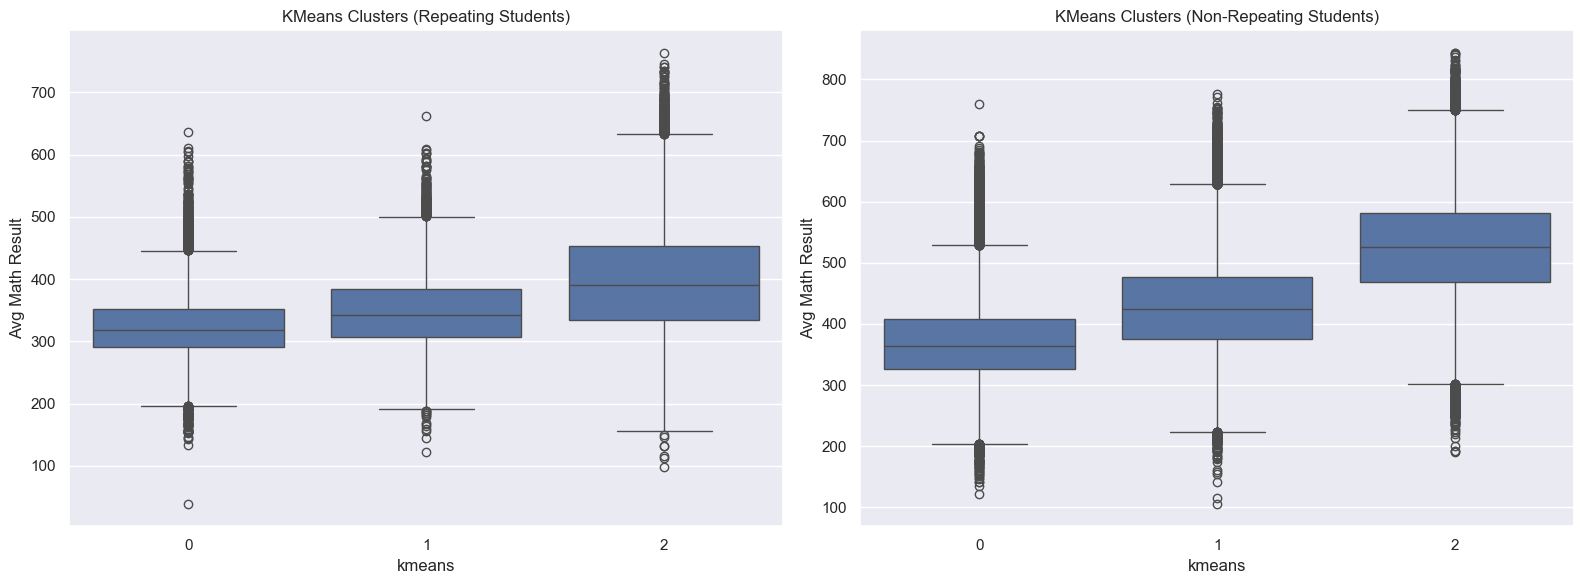

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(
    data=repeating,
    x="kmeans",
    y="Avg Math Result",
    ax=axes[0],
)
axes[0].set_title("KMeans Clusters (Repeating Students)")

sns.boxplot(
    data=not_repeating,
    x="kmeans",
    y="Avg Math Result",
    ax=axes[1],
)
axes[1].set_title("KMeans Clusters (Non-Repeating Students)")

plt.tight_layout()
plt.show()

TODO: Avaliar quais destes gráficos podem ser interessantes para mostrar

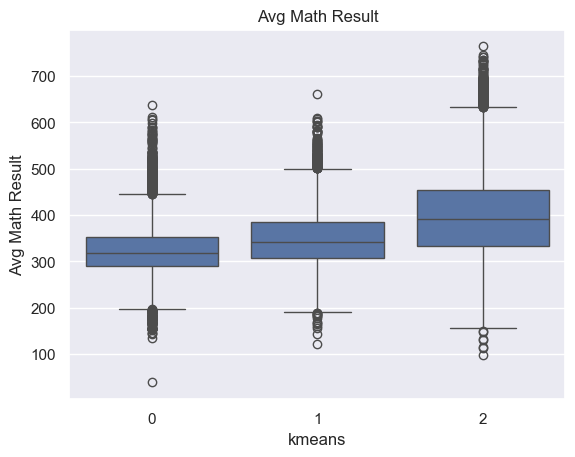

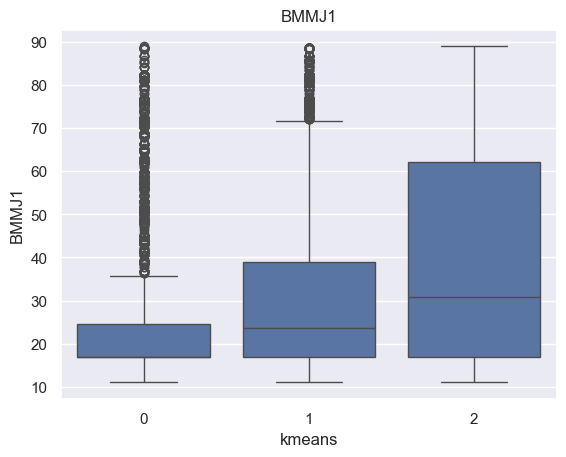

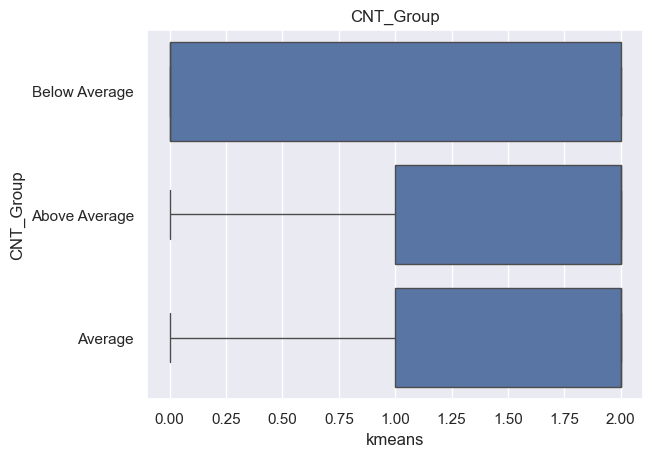

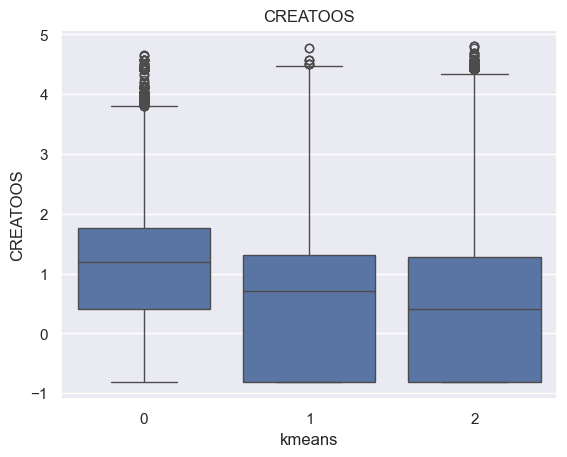

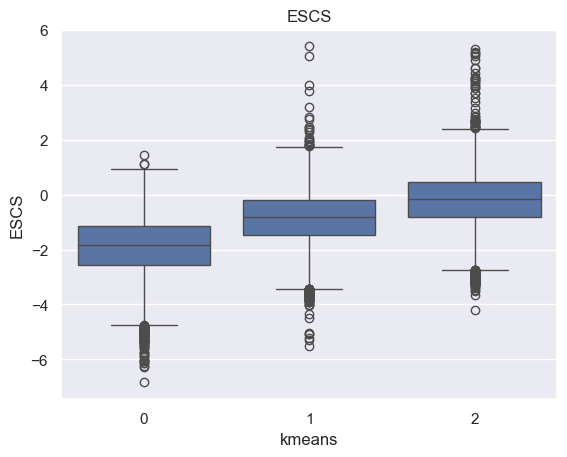

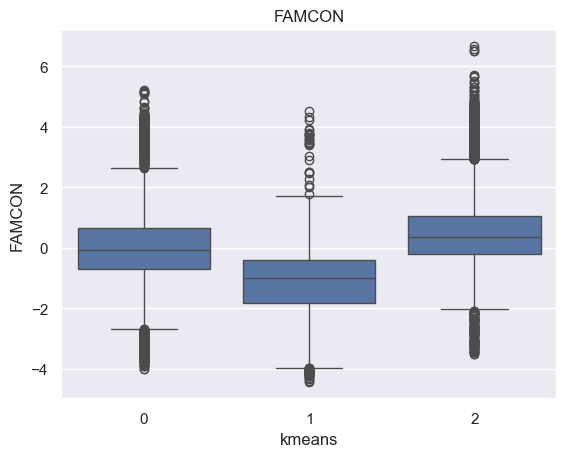

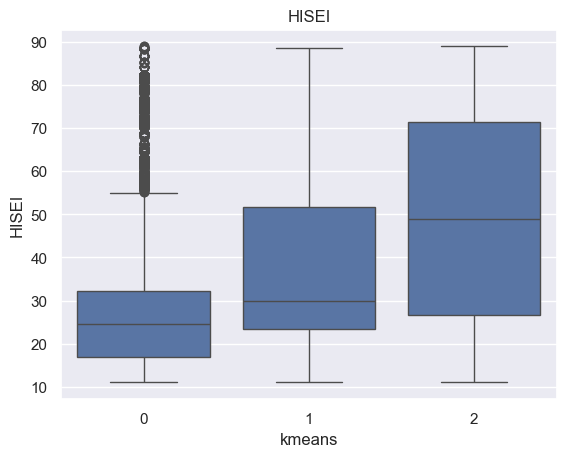

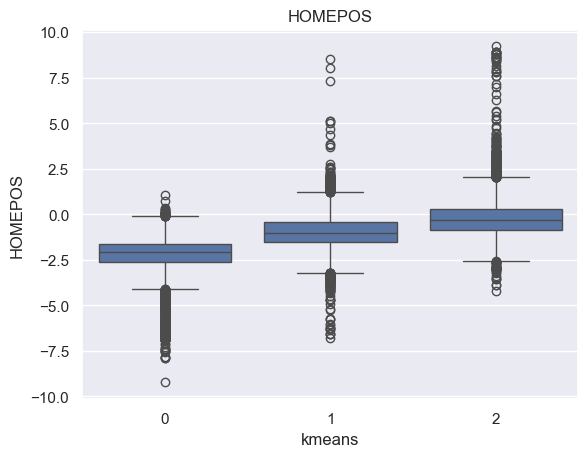

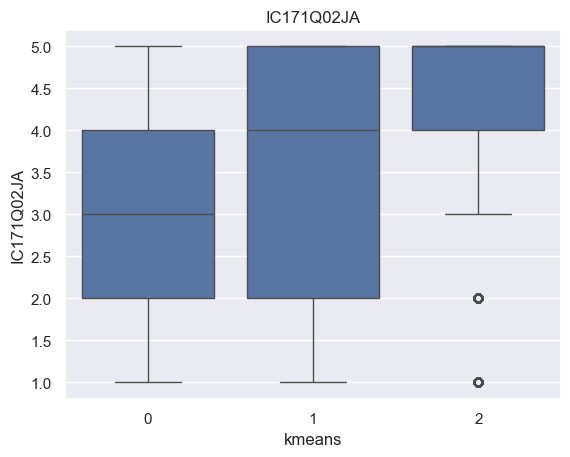

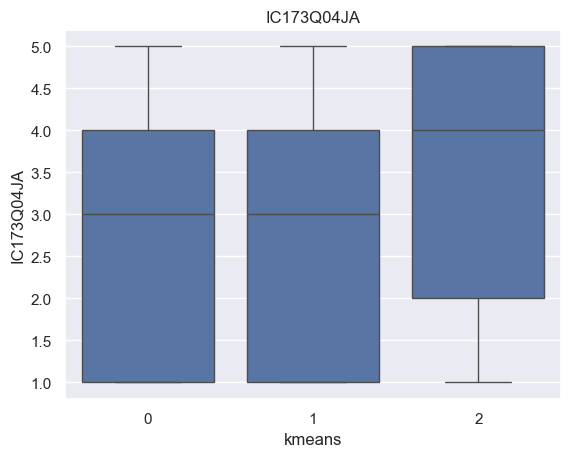

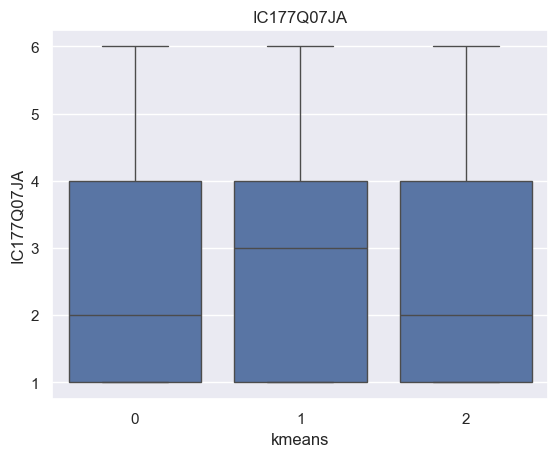

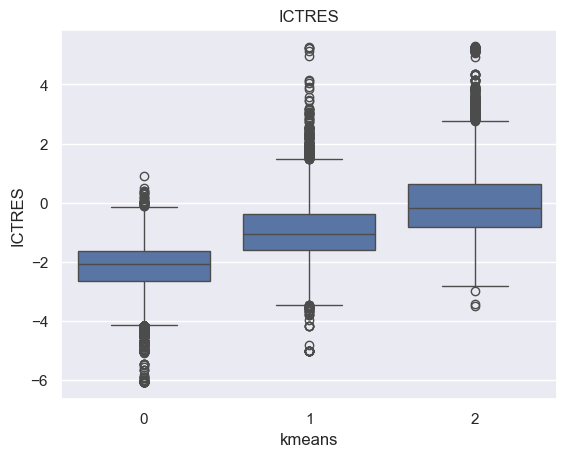

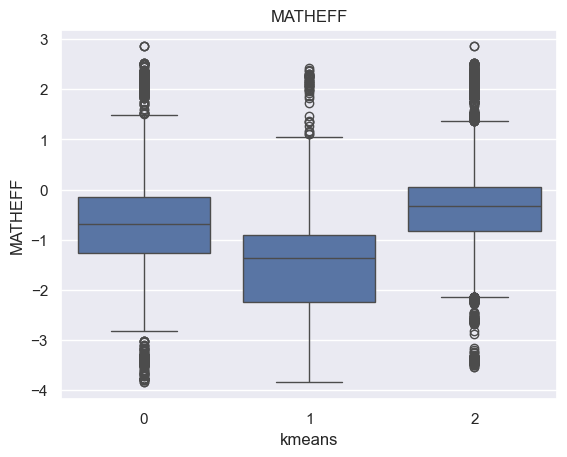

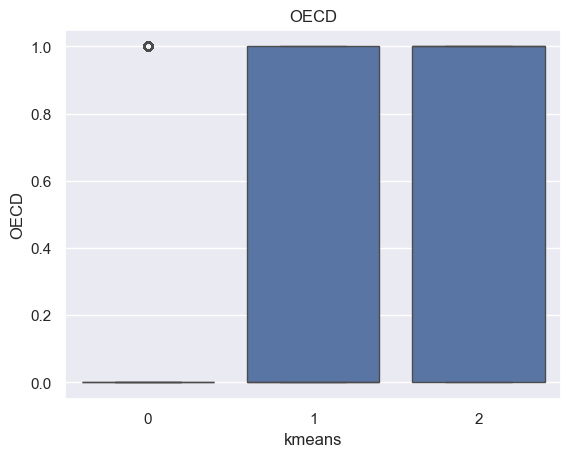

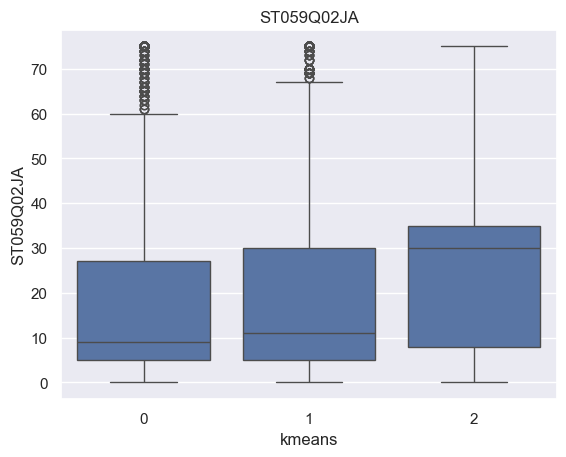

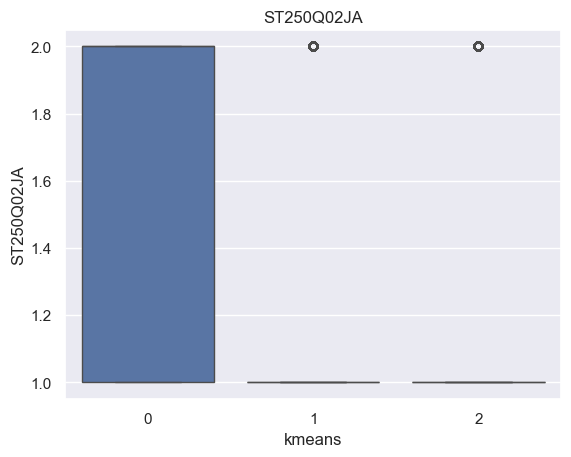

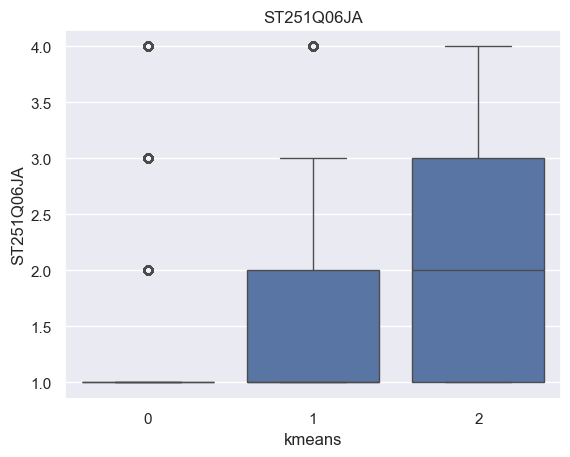

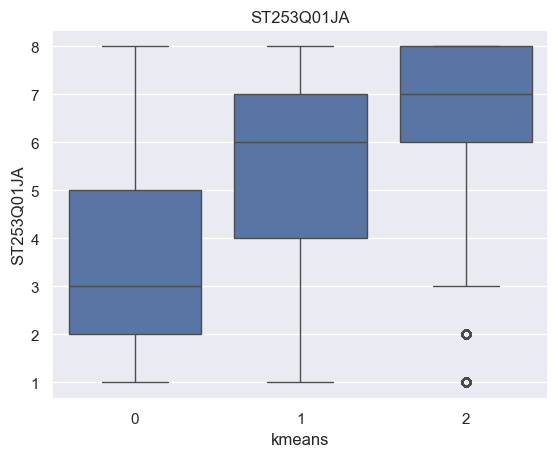

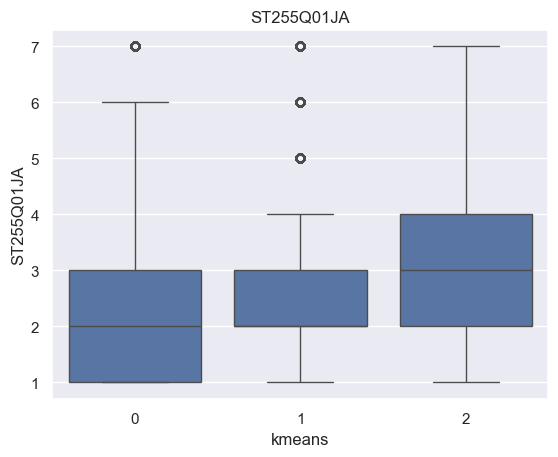

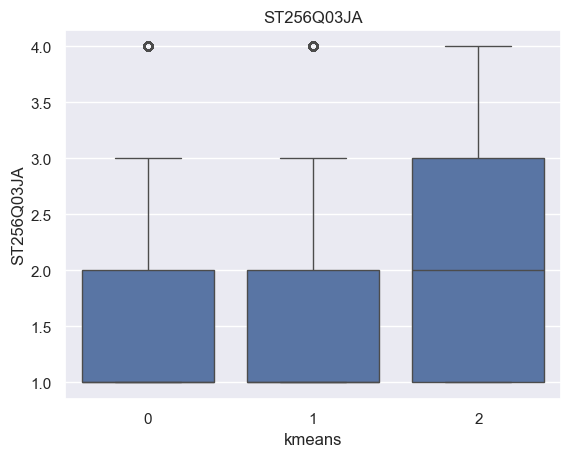

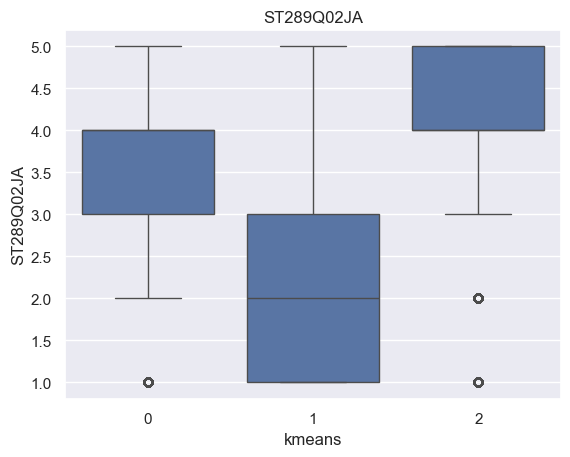

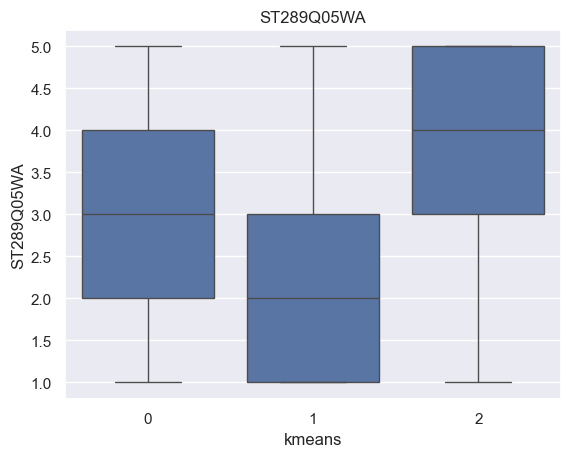

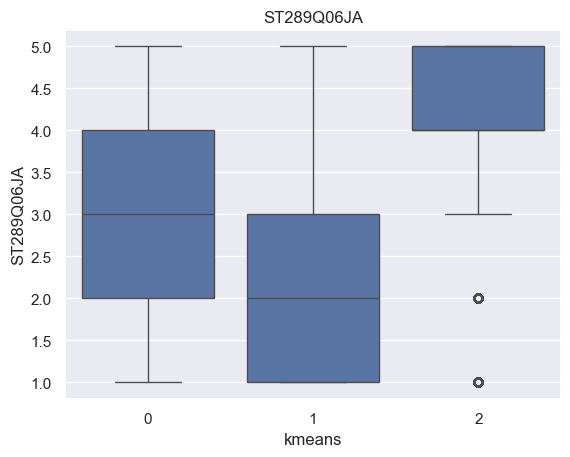

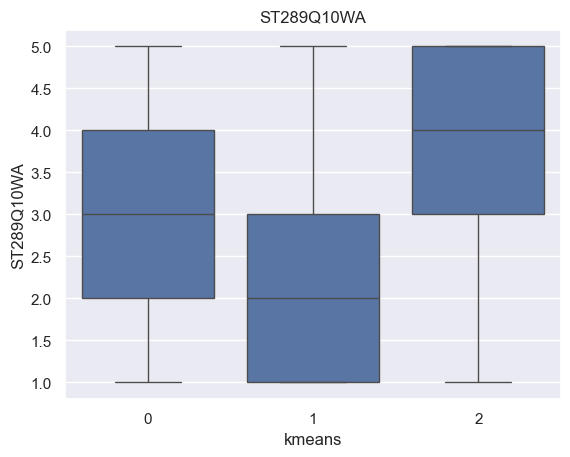

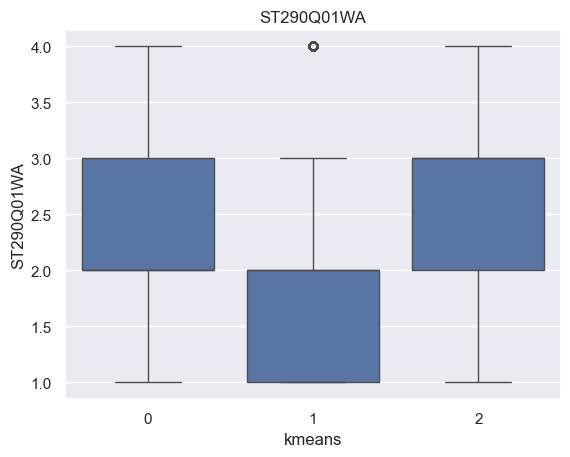

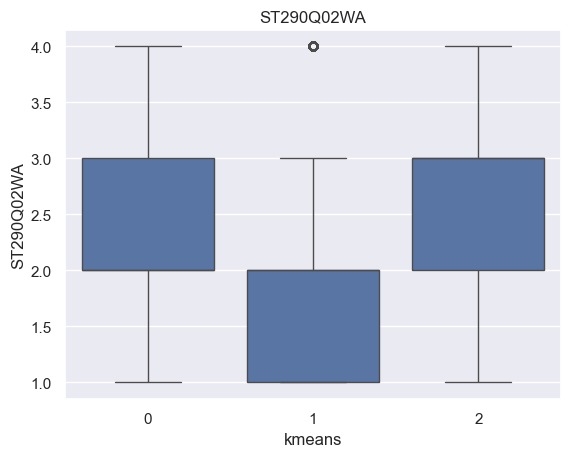

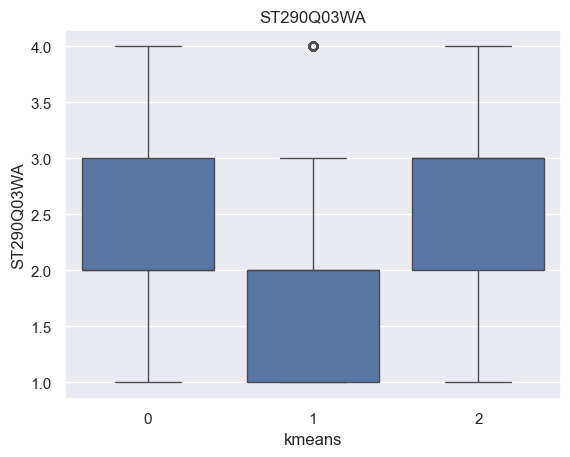

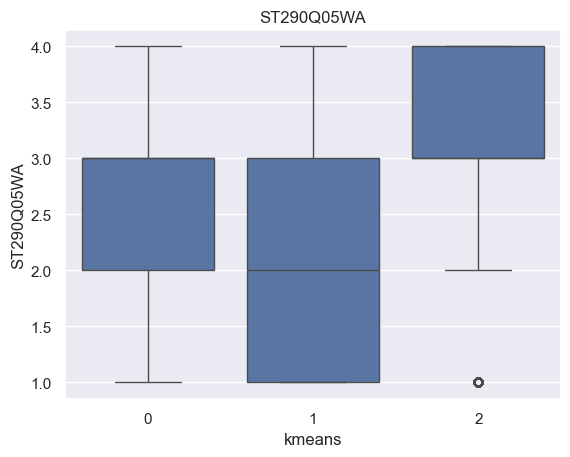

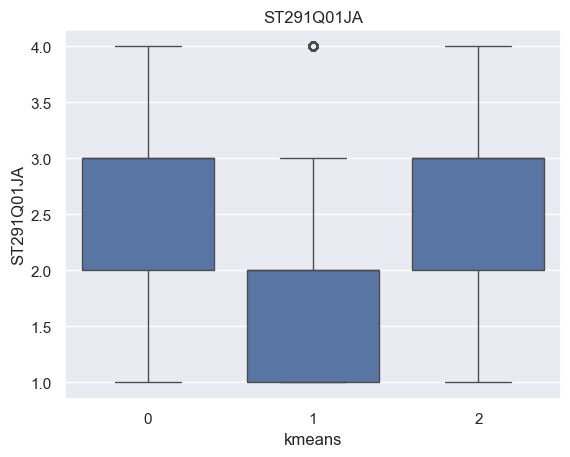

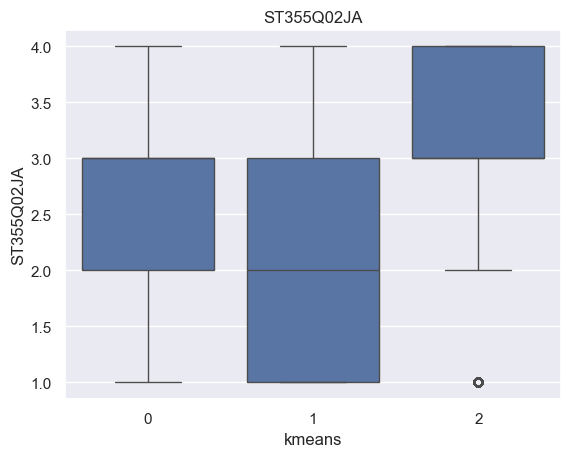

In [213]:
columns_to_plot = repeating.columns.drop(["kmeans", "REPEAT"])
for column in columns_to_plot:
    sns.boxplot(data=repeating, x="kmeans", y=column)
    plt.title(column)
    plt.show()

In [188]:
centroids_repeating = pd.DataFrame(
    kmeans_repeating.cluster_centers_,
    columns=X_encoded_repeating.drop(columns="kmeans").columns,
)
print(centroids_repeating.to_string())

      BMMJ1  CREATOOS      ESCS    FAMCON     HISEI   HOMEPOS  IC171Q02JA  IC173Q04JA  IC177Q07JA    ICTRES   MATHEFF      OECD  ST059Q02JA  ST250Q02JA  ST251Q06JA  ST253Q01JA  ST255Q01JA  ST256Q03JA  ST289Q02JA  ST289Q05WA  ST289Q06JA  ST289Q10WA  ST290Q01WA  ST290Q02WA  ST290Q03WA  ST290Q05WA  ST291Q01JA  ST355Q02JA  CNT_Group_Above Average  CNT_Group_Average  CNT_Group_Below Average
0 -0.373227  0.222905 -0.460316 -1.170999 -0.442973 -0.436931   -0.575442   -0.365206    0.205941 -0.207883 -1.092213  0.046812   -0.461137    0.100604   -0.258238   -0.335831   -0.543574   -0.389470   -1.127944   -1.113598   -1.160083   -0.820510   -0.769717   -0.712241   -0.750650   -0.850505   -0.741291   -0.424932                 0.417960           0.093348                 0.488693
1 -0.071273  0.117830  0.098368  0.044478 -0.066609  0.200118   -0.025911   -0.005508    0.117564  0.288968  0.135653  0.305014   -0.050915   -0.273224    0.070140    0.192186   -0.052066   -0.088726    0.080839   -0.00117

## Supervised Learning Aproach (Random Forest Classifier)

In [ ]:
#Cluster 0
X_0_repeating = X_encoded_repeating.copy()
X_0_repeating["cluster_0"] = (X_0_repeating["kmeans"] == 0).astype(int)

X_rep = X_0_repeating.drop(columns=["kmeans", "cluster_0"])
y_rep = X_0_repeating["cluster_0"]

model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_rep, y_rep)

importances_rep = pd.Series(model_rep.feature_importances_, index=X_rep.columns)

X_0_not_repeating = X_encoded_not_repeating.copy()
X_0_not_repeating["cluster_0"] = (X_0_not_repeating["kmeans"] == 0).astype(int)

X_nonrep = X_0_not_repeating.drop(columns=["kmeans", "cluster_0"])
y_nonrep = X_0_not_repeating["cluster_0"]

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_nonrep, y_nonrep)

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_, index=X_nonrep.columns
)

importance_df = pd.DataFrame(
    {
        "Repeating Cluster 0": importances_rep,
        "Non-Repeating Cluster 0": importances_nonrep,
    }
)

top_features = (
    (importances_rep.abs() + importances_nonrep.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)
importance_df = importance_df.loc[top_features]

importance_df = importance_df.sort_values(by="Repeating Cluster 0", ascending=False)

print("\nTop Feature Importances for Cluster 0 (Repeating vs Non-Repeating):")
print(importance_df.round(4))


Top Feature Importances for Cluster 0 (Repeating vs Non-Repeating):
                         Repeating Cluster 0  Non-Repeating Cluster 0
ICTRES                                0.2131                   0.1836
HOMEPOS                               0.1834                   0.2086
ST250Q02JA                            0.0939                   0.1701
ST253Q01JA                            0.0873                   0.0915
ESCS                                  0.0742                   0.1032
FAMCON                                0.0356                   0.0049
CNT_Group_Below Average               0.0350                   0.0259
HISEI                                 0.0258                   0.0415
OECD                                  0.0247                   0.0191
BMMJ1                                 0.0206                   0.0264


In [198]:
# Cluster 1

X_1_repeating = X_encoded_repeating.copy()
X_1_repeating["cluster_1"] = (X_1_repeating["kmeans"] == 1).astype(int)

X_rep = X_1_repeating.drop(columns=["kmeans", "cluster_1"])
y_rep = X_1_repeating["cluster_1"]

model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_rep, y_rep)

importances_rep = pd.Series(model_rep.feature_importances_, index=X_rep.columns)

X_1_not_repeating = X_encoded_not_repeating.copy()
X_1_not_repeating["cluster_1"] = (X_1_not_repeating["kmeans"] == 1).astype(int)

X_nonrep = X_1_not_repeating.drop(columns=["kmeans", "cluster_1"])
y_nonrep = X_1_not_repeating["cluster_1"]

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_nonrep, y_nonrep)

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_, index=X_nonrep.columns
)

importance_df = pd.DataFrame(
    {
        "Repeating Cluster 1": importances_rep,
        "Non-Repeating Cluster 1": importances_nonrep,
    }
)

top_features = (
    (importances_rep.abs() + importances_nonrep.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)
importance_df = importance_df.loc[top_features]

importance_df = importance_df.sort_values(by="Repeating Cluster 1", ascending=False)

print("\nTop Feature Importances for Cluster 1 (Repeating vs Non-Repeating):")
print(importance_df.round(4))


Top Feature Importances for Cluster 1 (Repeating vs Non-Repeating):
            Repeating Cluster 1  Non-Repeating Cluster 1
MATHEFF                  0.1634                   0.1353
FAMCON                   0.1489                   0.0449
ST289Q02JA               0.0723                   0.0111
ST289Q06JA               0.0683                   0.0113
ST289Q05WA               0.0555                   0.0125
HOMEPOS                  0.0498                   0.1159
ICTRES                   0.0440                   0.0727
ESCS                     0.0334                   0.1000
ST290Q03WA               0.0332                   0.0316
ST250Q02JA               0.0135                   0.0620


In [199]:
# Cluster 2
cluster = "cluster_2"

X_2_repeating = X_encoded_repeating.copy()
X_2_repeating[cluster] = (X_2_repeating["kmeans"] == 2).astype(int)

X_rep = X_2_repeating.drop(columns=["kmeans", cluster])
y_rep = X_2_repeating[cluster]

model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_rep, y_rep)

importances_rep = pd.Series(model_rep.feature_importances_, index=X_rep.columns)

X_2_not_repeating = X_encoded_not_repeating.copy()
X_2_not_repeating[cluster] = (X_2_not_repeating["kmeans"] == 2).astype(int)

X_nonrep = X_2_not_repeating.drop(columns=["kmeans", cluster])
y_nonrep = X_2_not_repeating[cluster]

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_nonrep, y_nonrep)

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_, index=X_nonrep.columns
)

importance_df = pd.DataFrame(
    {
        "Repeating Cluster 2": importances_rep,
        "Non-Repeating Cluster 2": importances_nonrep,
    }
)

top_features = (
    (importances_rep.abs() + importances_nonrep.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)

importance_df = importance_df.loc[top_features]
importance_df = importance_df.sort_values(by="Repeating Cluster 2", ascending=False)

print("\nTop Feature Importances for Cluster 2 (Repeating vs Non-Repeating):")
print(importance_df.round(4))


Top Feature Importances for Cluster 2 (Repeating vs Non-Repeating):
            Repeating Cluster 2  Non-Repeating Cluster 2
HOMEPOS                  0.1569                   0.1144
ICTRES                   0.1310                   0.0191
MATHEFF                  0.0776                   0.1688
ST253Q01JA               0.0730                   0.0210
ESCS                     0.0721                   0.1170
ST250Q02JA               0.0591                   0.0031
FAMCON                   0.0571                   0.0549
HISEI                    0.0270                   0.0567
ST255Q01JA               0.0234                   0.0714
BMMJ1                    0.0178                   0.0491


In [ ]:
model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_encoded_repeating.drop(columns=["kmeans"]), X_encoded_repeating["kmeans"])

importances_rep = pd.Series(
    model_rep.feature_importances_,
    index=X_encoded_repeating.drop(columns=["kmeans"]).columns,
)

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_encoded_not_repeating.drop(columns=["kmeans"]), X_encoded_not_repeating["kmeans"])

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_,
    index=X_encoded_not_repeating.drop(columns=["kmeans"]).columns,
)

importance_df = pd.DataFrame({
    "Repeating (KMeans)": importances_rep,
    "Non-Repeating (KMeans)": importances_nonrep
})

top_features = (importances_rep.abs() + importances_nonrep.abs()).sort_values(ascending=False).head(10).index

importance_df = importance_df.loc[top_features]
importance_df = importance_df.sort_values(by="Repeating (KMeans)", ascending=False)

print("\nTop Feature Importances for Predicting KMeans Clusters:")
print(importance_df.round(4))



Top Feature Importances for Predicting KMeans Clusters:
            Repeating (KMeans)  Non-Repeating (KMeans)
ICTRES                  0.1380                  0.0867
HOMEPOS                 0.1350                  0.1402
MATHEFF                 0.0821                  0.1189
FAMCON                  0.0744                  0.0377
ST253Q01JA              0.0666                  0.0478
ESCS                    0.0645                  0.0980
ST250Q02JA              0.0640                  0.0770
HISEI                   0.0247                  0.0452
ST255Q01JA              0.0181                  0.0446
BMMJ1                   0.0165                  0.0382


In [ ]:
silhouette_repeating = silhouette_score(
    X_encoded_repeating.drop(columns="kmeans"), kmeans_repeating.labels_
)
# silhouette_not_repeating = silhouette_score(
#     X_encoded_not_repeating.drop(columns="kmeans"), kmeans_not_repeating.labels_
# )

print(f"Silhouette Score (Repeating): {silhouette_repeating:.3f}")
# print(f"Silhouette Score (Non-Repeating): {silhouette_not_repeating:.3f}")

Silhouette Score (Repeating): 0.124
